In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import matplotlib.colors as colors
from sklearn.utils import resample

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.ensemble import GradientBoostingClassifier

In [63]:
import modules
import importlib
importlib.reload(modules)

<module 'modules' from 'C:\\Users\\shfar\\Desktop\\SU\\Thesis\\thesis\\modules.py'>

In [64]:
bounded_dists = modules.get_bounded_distribution()
bounded_dists

{'arcsine': <scipy.stats._distn_infrastructure.rv_frozen at 0x1ecb8c579e8>,
 'beta_1_2': <scipy.stats._distn_infrastructure.rv_frozen at 0x1ecb8c57f28>,
 'powerlaw_0.3': <scipy.stats._distn_infrastructure.rv_frozen at 0x1ecb8c57e10>,
 'trapezoid_0.3_0.8': <scipy.stats._distn_infrastructure.rv_frozen at 0x1ecb8c57048>,
 'traing_0.3': <scipy.stats._distn_infrastructure.rv_frozen at 0x1ecb8862198>,
 'uniform': <scipy.stats._distn_infrastructure.rv_frozen at 0x1ecb8862cf8>}

In [88]:
kde_df = modules.get_kde_estimates(bounded_dists, 20, 500, 20, 0.01)

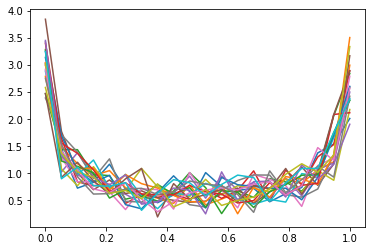

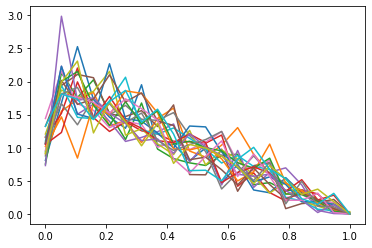

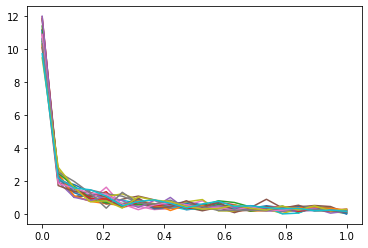

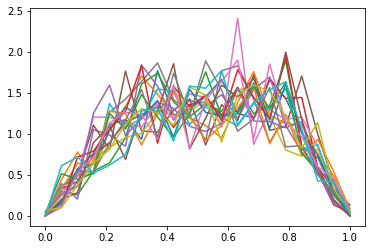

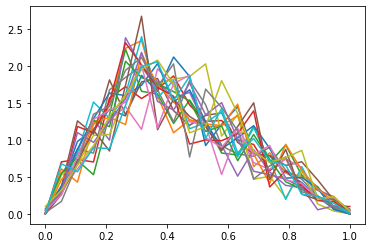

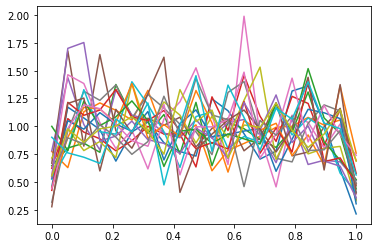

In [101]:
for name,distr in (bounded_dists.items()):
    fig, ax = plt.subplots()
    temp = kde_df.loc[kde_df['dist']==name]
    for i in range(20):
        y = temp.iloc[i]
        y = y[0:20]
        x = np.linspace(0,1,20)

        ax.plot(x,y)   

In [18]:
def prepare_data(df, test_size):
    X = df.drop('dist', axis=1)
    y = df['dist']
    
    # Scaling data
    scaler = StandardScaler()
    scaler.fit(X)
    X_scaled = scaler.transform(X)

    # train-test split
    X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size = test_size, random_state=11)
    return X, y, X_train, X_test, y_train, y_test

In [23]:
def svm_model(X, y, X_train, X_test, y_train, y_test, cv):
    param_grid = [
        {'C':np.logspace(0.1, 50, 20),
         'gamma':np.logspace(0.001, 10, 20), 
         'kernel':['rbf']},
    ]

    optimal_params = GridSearchCV(SVC(), param_grid,cv=5, verbose=0)
    optimal_params.fit(X_train, y_train)

    clf_svm = SVC(random_state=10, C=optimal_params.best_params_['C'], gamma=optimal_params.best_params_['gamma'])
    clf_svm.fit(X_train, y_train)

    y_pred = clf_svm.predict(X_test)
    scores = cross_val_score(clf_svm, X, y, cv=cv)
    accuracy = scores.mean()
    
    return y_pred, accuracy, scores

In [102]:
X, y, X_train, X_test, y_train, y_test = prepare_data(kde_df, 0.2)
svm_model(X, y, X_train, X_test, y_train, y_test, 5)

(array(['uniform', 'uniform', 'uniform', 'uniform', 'uniform', 'uniform',
        'uniform', 'uniform', 'uniform', 'uniform', 'uniform', 'uniform',
        'uniform', 'uniform', 'uniform', 'uniform', 'uniform', 'uniform',
        'uniform', 'powerlaw_0.3', 'uniform', 'uniform', 'uniform',
        'uniform'], dtype=object),
 1.0,
 array([1., 1., 1., 1., 1.]))

In [104]:
y_pred

array(['traing_0.3', 'arcsine', 'uniform', 'traing_0.3', 'arcsine',
       'trapezoid_0.3_0.8', 'arcsine', 'arcsine', 'powerlaw_0.3',
       'beta_1_2', 'arcsine', 'beta_1_2', 'beta_1_2', 'trapezoid_0.3_0.8',
       'traing_0.3', 'trapezoid_0.3_0.8', 'traing_0.3', 'uniform',
       'traing_0.3', 'powerlaw_0.3', 'beta_1_2', 'arcsine',
       'trapezoid_0.3_0.8', 'trapezoid_0.3_0.8'], dtype=object)

In [105]:
y_test

94            traing_0.3
16               arcsine
101              uniform
98            traing_0.3
0                arcsine
72     trapezoid_0.3_0.8
9                arcsine
2                arcsine
58          powerlaw_0.3
36              beta_1_2
6                arcsine
29              beta_1_2
35              beta_1_2
75     trapezoid_0.3_0.8
99            traing_0.3
68     trapezoid_0.3_0.8
88            traing_0.3
117              uniform
87            traing_0.3
54          powerlaw_0.3
30              beta_1_2
15               arcsine
60     trapezoid_0.3_0.8
78     trapezoid_0.3_0.8
Name: dist, dtype: object

In [62]:
for i in range(5,25):
    kde_df = modules.get_kde_estimates(bounded_dists, 20, 500, i)
    X, y, X_train, X_test, y_train, y_test = prepare_data(kde_df, 0.2)
    a, b, c = svm_model(X, y, X_train, X_test, y_train, y_test, 5)
    print(b)
    print(c)

1.0
[1. 1. 1. 1. 1.]
1.0
[1. 1. 1. 1. 1.]
1.0
[1. 1. 1. 1. 1.]
1.0
[1. 1. 1. 1. 1.]
1.0
[1. 1. 1. 1. 1.]
1.0
[1. 1. 1. 1. 1.]
1.0
[1. 1. 1. 1. 1.]
1.0
[1. 1. 1. 1. 1.]
1.0
[1. 1. 1. 1. 1.]
1.0
[1. 1. 1. 1. 1.]
1.0
[1. 1. 1. 1. 1.]
1.0
[1. 1. 1. 1. 1.]
1.0
[1. 1. 1. 1. 1.]
1.0
[1. 1. 1. 1. 1.]
1.0
[1. 1. 1. 1. 1.]
1.0
[1. 1. 1. 1. 1.]
1.0
[1. 1. 1. 1. 1.]
1.0
[1. 1. 1. 1. 1.]
1.0
[1. 1. 1. 1. 1.]
1.0
[1. 1. 1. 1. 1.]
